# Old Timer Tournament data analysis.

The Old Timer Tournament is a recurring event in which players compete in random games. Players are paired in a triple-elimination bracket, and at each pairing they face eachother in a game that is randomly chosen (without replacement) from a larger pool of games. Most are video games from a broad set of genres, but there are also some traditional board games.

Here, we want to quantify who the best old timer competitors are. We will compute each player's elo, and examine other metrics. 

In [1]:
# -*- coding: utf-8 -*-
"""
Visualize results and games from OT-Tournament data.
Compute and visualize Elo for OT-Tournament data.
Validates elo model, and 

@author: Bart
"""

##Run these prior to running any code. 
%load_ext autoreload
%autoreload 2

#Import libraries and define useful functions.
import sqlite3
import itertools

import pandas as pd
import numpy as np
from scipy import optimize
from scipy import stats
from matplotlib import cm
import matplotlib.pyplot as plt


In [2]:
######################################INITIALIZE EVERYTHING

REALMIN = np.finfo(np.double).tiny      #The smallest double value in Python. 

#Logistic function for computing probability p1 beats p2 based on elo
#b: softmax temperature
#
#x: player 1's elo
#y: player 2's elo
#RETURN: the predicted probability that player 1 beats player 2
logistic = lambda b,x,y: 1.0/(1+np.exp(-b*(x-y)))

#Cost function for binomial data. Log likelihood of data assuming that each 
#trial is independent. I.E., cost = SUM(y*log(h) + (1-y)*log(1-h))
#
#y: whether p1 beat p2 (true, 1) or not (false, 0) in a given match
#h: predicted probability that p1 won.
#RETURNS: negative log likelihood of matchup outcomes under model. 
#I.E., -log(p(data|model))
cost = lambda y,h: -np.sum(y*np.log(np.max([h,np.ones(len(h))*REALMIN],axis=0))+
       (1-y)*np.log(np.max([1-h,np.ones(len(h))*REALMIN],axis=0))); 

#Computes the predicted outcome of series of matches based on player elo. 
#Assumes default elo for never-before-seen player.
#
#matches: pandas table that includes 'player1', and 'player2' columns. 
#elo: dictionary containing each player's elo. 
#default_elo: the starting estimate of a player's elo. Arbitrary. 
#RETURNS: vector of predicted probabilities that p1 wins each match.
def predict_outcome(matches,elo,softmax_temp,default_elo=1000): 
    num_match = matches.shape[0]

    predictions = []
    for i in range(0,num_match):
        
        #get player1 and player2 elo
        try:
            p1_elo = elo[matches['Player1'].iloc[i]]
        except KeyError:
            p1_elo = default_elo
        try:
            p2_elo = elo[matches['Player2'].iloc[i]]
        except KeyError:
            p2_elo = default_elo
            
            
        predictions.append(logistic(softmax_temp,p1_elo,p2_elo))

    return np.array(predictions)
                           
#Computes or updates a player's elo based on matches. 
#matches: pandas table that includes 'player1','player2', and 'winner' columns. 
#elo_dict: dictionary object w/ starting values for each player's elo
#learning_rate: parameter that controls how quickly elo estimates are adjusted
#softmax_temp: parameter that determines how steeply elo diffences change chances
#that a given player wins.
#default_elo: the starting estimate of a player's elo. Arbitrary. 
#RETURNS: a dictionary with each player's name as a key associated with their elo.
def calculateElo(matches,learning_rate,softmax_temp,elo_dict=None,default_elo=1000):

    #Can't initialize with an empty dictionary, so we do this instead.    
    if(elo_dict is None):
        elo_dict = {}

    num_match = matches.shape[0]

    for i in range(0,num_match):
        winner_is_p1 = (matches['Player1'].iloc[i] == matches['Winner'].iloc[i])+0
        
        
        #get player1 and player2 elo
        try:
            p1_elo = elo_dict[matches['Player1'].iloc[i]]
        except KeyError:
            p1_elo = default_elo
        try:
            p2_elo = elo_dict[matches['Player2'].iloc[i]]
        except KeyError:
            p2_elo = default_elo
            
        #predicts chance that p1 wins
        prediction = logistic(softmax_temp,p1_elo,p2_elo)
        
        #compute adjustment in elo based on outcome and update elo
        adjustment = learning_rate*((winner_is_p1) - prediction)
        elo_dict[matches['Player1'].iloc[i]] = p1_elo + adjustment
        elo_dict[matches['Player2'].iloc[i]] = p2_elo - adjustment

    return elo_dict

    
#Determines players' win rates in specific genres.
#
#outcomes: a table in which rows are matches with each player's name, 
#whether they won, and the genre of the game that they played.
#rep_with_average: flag indicating whether player's average win rate will be used
#in place of missing data.
#RETURNS: a table indexed by players with each player's win rates in all genres.
def getGenreWinrates(outcomes,rep_with_average=True):
    
    #get unique genres and players
    genres = outcomes['genre'].drop_duplicates()
    players = outcomes['player1'].drop_duplicates()
    
    #iterate through players and genres and grab genre-specific win-rate
    performance_by_genre = pd.DataFrame(columns=genres,index=players)
    for p in players:
        for g in genres:
            #get win rate for player p in genre g
            performance_by_genre[g][p] = np.mean(outcomes['won'].loc[
                    (outcomes['genre']==g) & (outcomes['player1']==p)])
            
            #if player has never played genre, assume their win rate is their overall win rate in dataset
            if(np.isnan(performance_by_genre[g][p]) and rep_with_average):
                performance_by_genre[g][p] = np.mean(outcomes['won'].loc[outcomes['player1']==p])
                
    return performance_by_genre
                
#Predicts match outcomes based on 
#
#matches: pandas table that includes 'player1','player2', and 'genre' columns. 
#whether they won, and the genre of the game that they played.
#RETURNS: a table indexed by players with each player's win rates in all genres.
def predict_outcome_genre(matches,genre_winrates):
    
    #combines win rate from player1 and player2
    #Assumes that player1 and player2 win or lose *independently* and cannot draw.
    #Thus, only possible outcomes are p1&!p2, or !p1&p2.
    p1_beats_p2 = lambda p1,p2: (p1*(1-p2))/((p1*(1-p2))+(p2*(1-p1)))

    num_match = matches.shape[0]
    predictions = np.empty((num_match,))
    for i in range(0,num_match):
        player1 = matches['Player1'].iloc[i]
        player2 = matches['Player2'].iloc[i]
        genre = matches['Genre'].iloc[i]
        
        #get probability that player1 wins given genre
        try:
            p1 = genre_winrates[genre][player1]
        except KeyError:
            p1 = .5     #if data missing, assume .5
        #get probability that player2 wins given genre
        try:
            p2 = genre_winrates[genre][player2]
        except KeyError:
            p2 = .5     #if data missing, assume .5
        
        #combine expected win rates to get a prediction
        try:
            predictions[i] = p1_beats_p2(p1,p2)
        except ZeroDivisionError:#if both players always win or never win in this genre
            predictions[i] = .5
        
    return predictions
    
    
#Queries SQLlite database.
#cur: a cursor pointing to a sqllite database
#query: a SQL query to be applied to the database given by cur.
def getData(cur,query):
    cur.execute(query)                                          #executes query
    dataout = cur.fetchall()                                    #get all data
    colnames = [desc[0] for desc in cur.description]            #pull out col names
    data = pd.DataFrame.from_records(dataout,columns=colnames)  #convert to a Pandas Dataframe
    return data

## Descriptive statistics.

Who are the players that win the most? What are the most common genres of game?

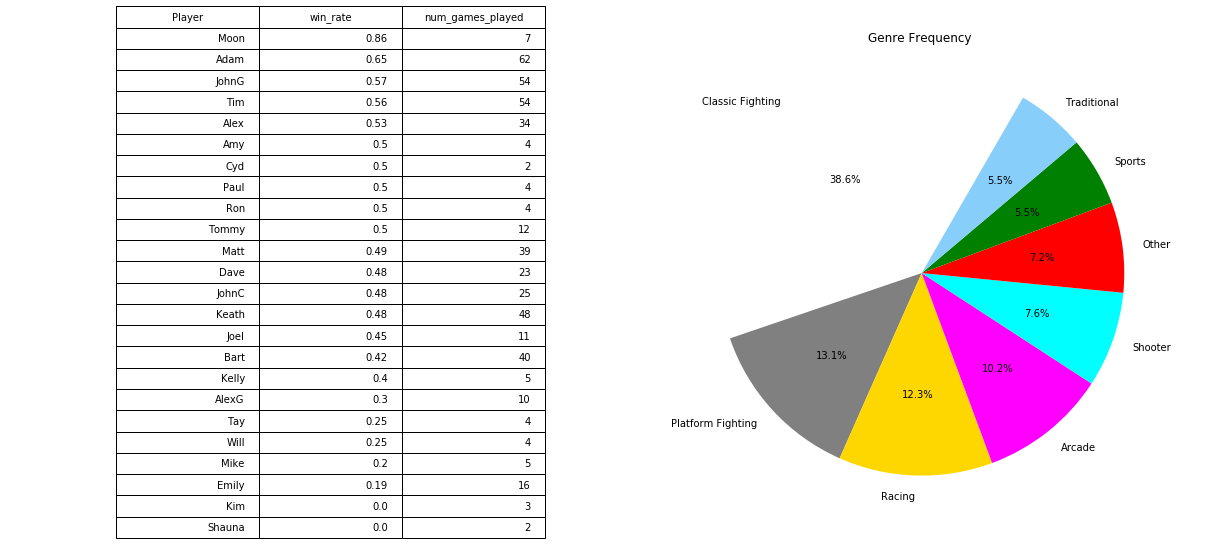

In [8]:
#Get a feel for the dataset
#What are the 

#Connect to database
conn = sqlite3.connect(database='OldTimer.db')
cur = conn.cursor()

#How often do specific genres come up?
genre_query = '''
SELECT genre,COUNT(genre)/236.0 as freq FROM Matches
LEFT JOIN Games ON games.game=Matches.game
GROUP BY genre
ORDER BY freq DESC
'''
genre_data = getData(cur,genre_query)

#Who are our players, how many games have they played, and how often do they win?
win_rate_query = '''
SELECT player1 as Player,ROUND(AVG(player1==winner),2) as win_rate,
COUNT(player1) as num_games_played FROM
(SELECT player1,winner FROM Matches
UNION ALL
SELECT player2,winner FROM Matches)
GROUP BY player1
ORDER BY win_rate DESC
'''
win_rate_data = getData(cur,win_rate_query)

#_,ax = plt.subplots(1,1,figsize=[10,10])
_,ax = plt.subplots(1,2,figsize=[17,7])
ax[0].axis('tight')
ax[0].axis('off')
tbl = ax[0].table(cellText=win_rate_data.values,colLabels=win_rate_data.columns,loc='center')
tbl.scale(.75,1.5)

#plot it
colors = ['white','gray','gold','magenta','cyan','red','green','lightskyblue']
ax[1].pie(genre_data['freq'],labels=genre_data['Genre'],autopct='%1.1f%%',
       startangle=60,colors=colors)
ax[1].set_title('Genre Frequency')
ax[1].axis('equal')
plt.tight_layout()
#%%

## Elo

Here we compute each player's Elo, which is a score that represents each player's "power." A player with higher elo is more likely to beat a player with lower elo, and two players with similar elo will be more evenly matched. Thus, elo should be closely related to overall win rate.

Elo is computed iteratively using a simple temporal-difference learner, whose learning rate is optimized on the data.

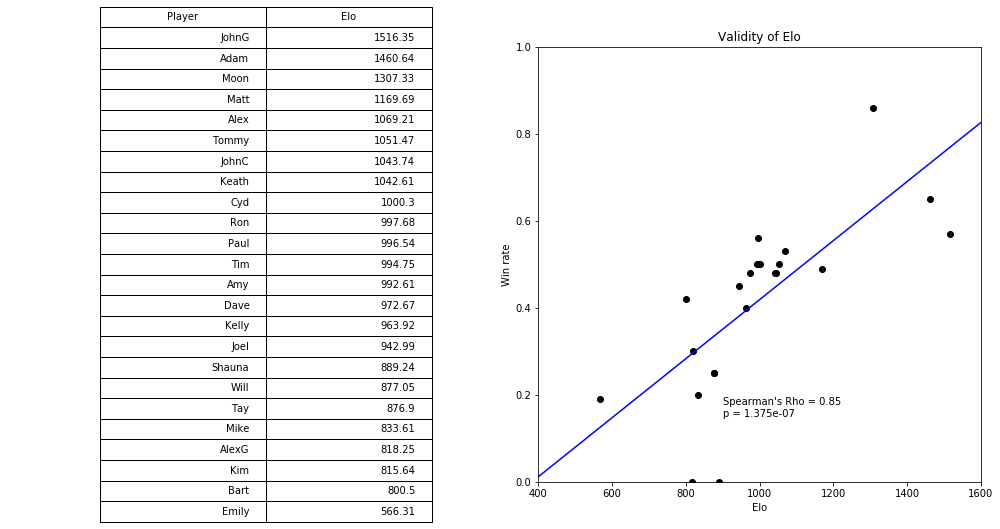

In [10]:
#Lets compute elo, and see how it relates to overall win rate.

#Get out the matchup data
query = '''
SELECT m.tournament,m.player1,m.player2,m.winner,
g.game,g.genre
FROM Matches as m 
LEFT JOIN Games as g ON m.game=g.game
'''
data = getData(cur,query)

#Setup objective function
objective = lambda par: cost((data['Player1']==data['Winner'])+0,predict_outcome(data,
          calculateElo(matches=data,learning_rate=par[0],softmax_temp=par[1]),
          softmax_temp=par[1]))

#Fit model, and calculate elo based on model. 
optout = optimize.minimize(objective,x0=[100,.001],method='Nelder-Mead')
best_parameters = optout['x']
elo_dict = calculateElo(matches=data,learning_rate=best_parameters[0],
         softmax_temp=best_parameters[1])

#Sort and round elo data so it's more presentable. 
#Concatenate it to win rate table for easy correlation.
elo_table = pd.concat([pd.DataFrame([(x,np.round(elo_dict[x],2)) for x in elo_dict.keys()],
         columns=('Player','Elo')).sort_values(by=['Elo'],ascending=False).set_index('Player'),
         win_rate_data.set_index('Player')],axis=1,join='inner').sort_values(by=['Elo'],ascending=False)


#Table for elo
_,ax = plt.subplots(1,2,figsize=[14,7])
ax[0].axis('tight')
ax[0].axis('off')
tbl = ax[0].table(cellText=[(x,y) for x,y in zip(elo_table.index,elo_table['Elo'])],
        colLabels=['Player','Elo'],loc='center')
tbl.scale(.75,1.5)

#Visualize relationship between elo & win rate.
m,b = np.polyfit(elo_table['Elo'],elo_table['win_rate'],1)
rho,p = stats.spearmanr(elo_table['Elo'],elo_table['win_rate'])
ax[1].plot([400,1600],m*np.array([400,1600])+b,'-',color='blue')
ax[1].scatter(x=elo_table['Elo'],y=elo_table['win_rate'],color=[0,0,0])
ax[1].set_ylabel('Win rate')
ax[1].set_xlabel('Elo')
ax[1].set_ylim([0,1])
ax[1].set_xlim([400,1600])
ax[1].set_title('Validity of Elo')
ax[1].text(900,.15,"Spearman's Rho = "+str(round(rho,2))+'\np = '+str(round(p,10)))
plt.tight_layout()


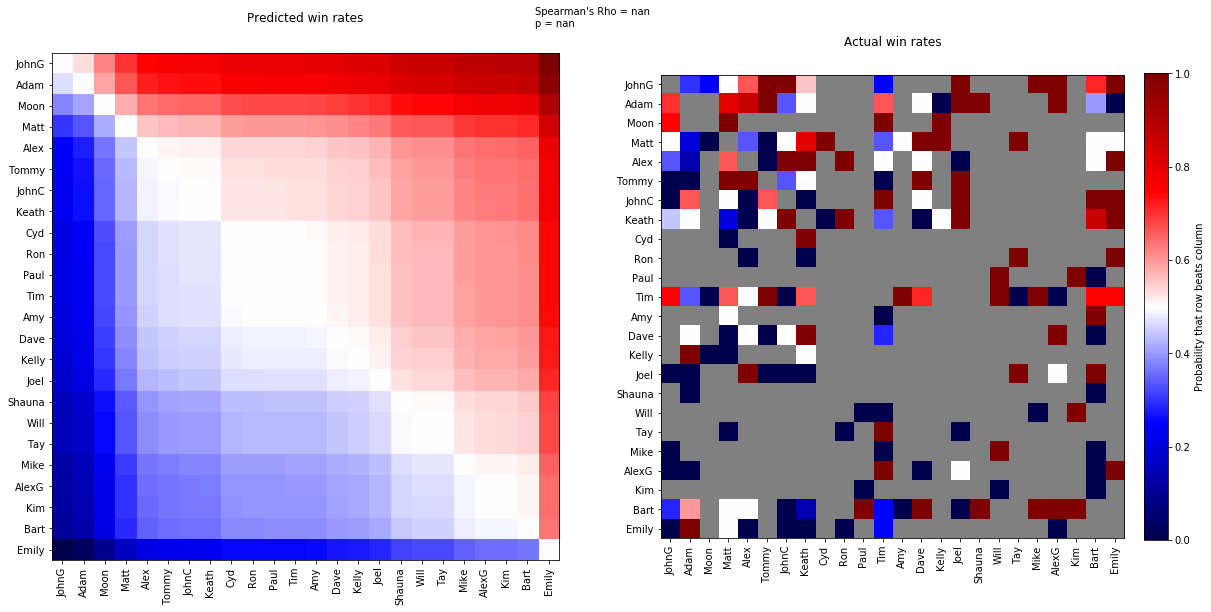

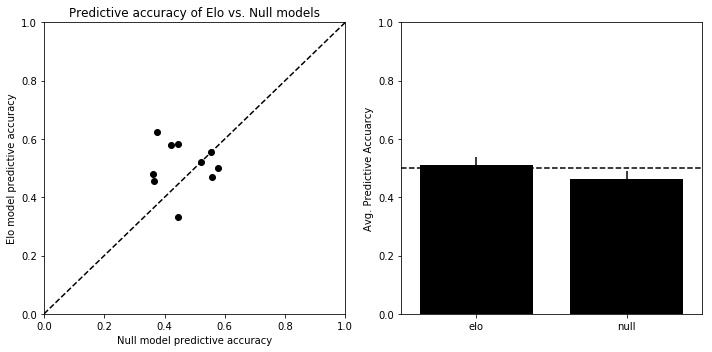

In [12]:
#Here we validate our elo model. Lets look at historical matchup winrate between players, and 
#see how this differs from the matchup winrate predicted by our elo model.
#
#We can compare the predictions of our elo model to a null model that treats every match as a 
#coin toss.


#Pull out the win rate of each player against every other opponent
matchup_winrate_query = '''
SELECT Tournament,player1,player2,winner,genre FROM
(SELECT tournament,player1,player2,winner,genre FROM Matches 
JOIN Games on Matches.game=Games.game
UNION ALL
SELECT tournament,player2,player1,winner,genre FROM Matches 
JOIN Games on Matches.game=Games.game)
'''
matchup_winrate = getData(cur,matchup_winrate_query)

#Pull out historical matchup statistics.
p1_win_rate_actual = np.reshape([np.mean(matchup_winrate['winner'].loc[(matchup_winrate['player1']==x) 
        & (matchup_winrate['player2']==y)]==x) 
        for x,y in itertools.product(elo_table.index,elo_table.index)],
        [elo_table.shape[0],elo_table.shape[0]])

#Predict the outcome of every possible matchup, and turn it into a matrix
p1_win_rate_predicted = np.reshape([logistic(best_parameters[1],x,y) for x,y in 
        itertools.product(elo_table['Elo'],elo_table['Elo'])],[elo_table.shape[0],
        elo_table.shape[0]])

rho_wr,p_wr = stats.spearmanr(p1_win_rate_predicted.flatten(),p1_win_rate_actual.flatten())

#Predicted win rate plot.
_,ax = plt.subplots(1,2,figsize=[20,10])
cmap = cm.seismic
cmap.set_bad('grey')
ax[0].matshow(p1_win_rate_predicted,cmap='seismic')
ax[0].set_xticks(np.arange(0,p1_win_rate_predicted.shape[0]))
ax[0].set_xticklabels(elo_table.index,rotation=90)
ax[0].set_yticks(np.arange(0,p1_win_rate_predicted.shape[0]))
ax[0].set_yticklabels(elo_table.index)
ax[0].set_title('Predicted win rates')
ax[0].xaxis.set_ticks_position('bottom')

#Actual win rate plot
cax = ax[1].matshow(p1_win_rate_actual,cmap='seismic')
ax[1].set_xticks(np.arange(0,p1_win_rate_predicted.shape[0]))
ax[1].set_xticklabels(elo_table.index,rotation=90)
ax[1].set_yticks(np.arange(0,p1_win_rate_predicted.shape[0]))
ax[1].set_yticklabels(elo_table.index)
ax[1].set_title('Actual win rates')
ax[1].xaxis.set_ticks_position('bottom')
ax[1].text(-7,-3,"Spearman's Rho = "+str(round(rho_wr,2))+'\np = '+str(round(p_wr,10)))
cbar = plt.gcf().colorbar(cax,ax=ax[1],fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Probability that row beats column')
#%%
#Leave-one-tournament-out validation on parameterized elo model
tournament_labels = data['Tournament'].drop_duplicates()
predictive_accuracy = pd.DataFrame(np.empty((len(tournament_labels),3))*np.nan,columns=['elo','null','genre']) 
for t in tournament_labels:
    #compute elo 
    temp_elo = calculateElo(matches=data.loc[data['Tournament'] != t],learning_rate=best_parameters[0],
             softmax_temp=best_parameters[1])
    
    #predictions of elo and a null model, and actual outcomes
    predictions_elo = predict_outcome(data.loc[data['Tournament']==t],temp_elo,softmax_temp=best_parameters[1])
    predictions_null = .5*np.ones((np.sum(data['Tournament']==t)))
    outcome = data['Player1'].loc[data['Tournament']==t] == data['Winner'].loc[data['Tournament']==t]
    
    #accuracy, in log-likelihood, of elo and null model
    predictive_accuracy['elo'][t-1] = np.mean(outcome==(predictions_elo>.5))
    predictive_accuracy['null'][t-1] = np.mean(outcome==(predictions_null>.5))
    
#Plot performance of elo model vs. null model
_,ax = plt.subplots(1,2,figsize=[10,5])
ax[0].scatter(x=predictive_accuracy['null'],y=predictive_accuracy['elo'],color=[0,0,0])
ax[0].set_ylim([0,1])
ax[0].set_xlim([0,1])
ax[0].set_xlabel('Null model predictive accuracy')
ax[0].set_ylabel('Elo model predictive accuracy')
ax[0].plot(ax[0].get_xlim(),ax[0].get_ylim(),'--k')
ax[0].set_title('Predictive accuracy of Elo vs. Null models')

ax[1].bar([0,1],height=np.mean(predictive_accuracy[['elo','null']],axis=0),width=.75,align='center',
        yerr=stats.sem(predictive_accuracy[['elo','null']],axis=0),color=[0,0,0])
ax[1].set_xlim([-.5,1.5])
ax[1].plot([-.5,1.5],[.5,.5],'--k')
ax[1].set_xticks([0,1])
ax[1].set_ylim([0,1])
ax[1].set_ylabel('Avg. Predictive Accuarcy')
ax[1].set_xticklabels(predictive_accuracy.columns)

plt.tight_layout()


## Alternative models! 

The elo model doesn't really do that much better than the dumbest possible null model.

Perhaps we can take a different approach: maybe players have differnet power levels in certain genres, so we should assign them a genre-specific score, and use that to make predictions. This is like using an elo model with more free parameters.

/home/bmassi/anaconda3/envs/leelab/lib/python3.7/site-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in double_scalars
/home/bmassi/anaconda3/envs/leelab/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
/home/bmassi/anaconda3/envs/leelab/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater


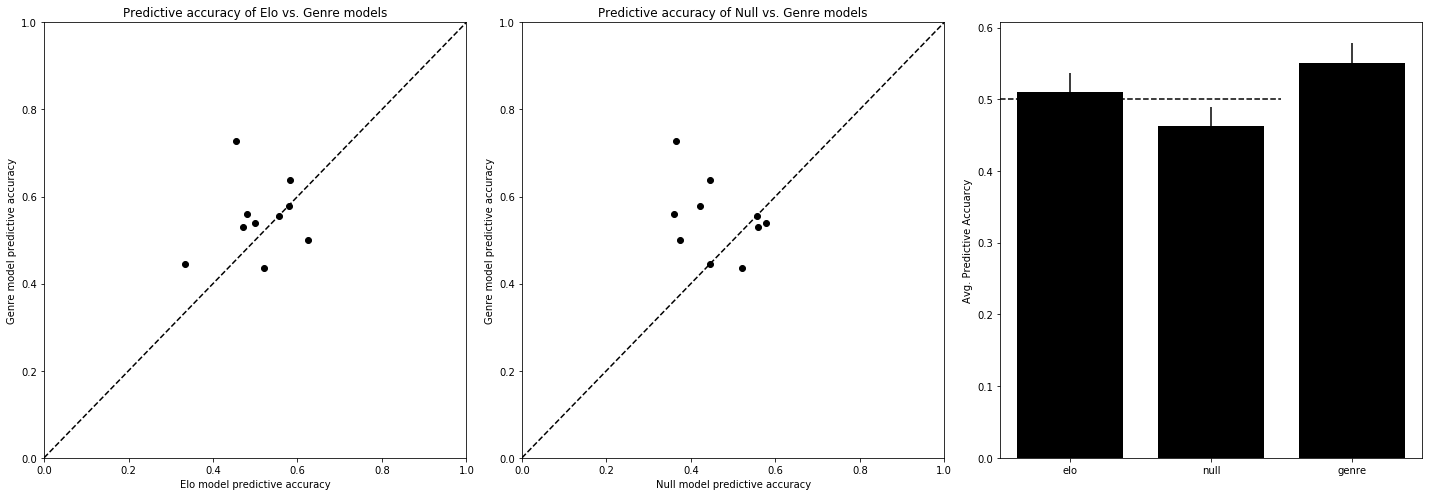

In [18]:
#Model performance in specific genres.

#search dataset 
#pulls out players, and their win rate in specific genres
genre_outcome_query = '''
SELECT Tournament,player1,player1=winner as won,genre FROM
(SELECT Tournament,player1,winner,genre FROM Matches 
JOIN Games on Matches.game=Games.game
UNION ALL
SELECT tournament,player2,winner,genre FROM Matches 
JOIN Games on Matches.game=Games.game)
ORDER BY tournament
'''
outcome_by_genre = getData(cur,genre_outcome_query)

#Grab genre-specific win-rate
genre_winrates = getGenreWinrates(outcome_by_genre,rep_with_average=False)      

#Leave-one-tournament-out validation of elo model vs. genre model.
tournament_labels = data['Tournament'].drop_duplicates()
predictive_accuracy_genre = []
predictive_cost_genre = []
for t in tournament_labels:
    #compute elo 
    #temp_elo = calculateElo(matches=data.loc[data['Tournament'] != t],learning_rate=best_parameters[0],
    #             softmax_temp=best_parameters[1])
    temp_genre_winrates = getGenreWinrates(outcome_by_genre.loc[outcome_by_genre['Tournament'] != t]) 
    
    #predictions of elo and genre model, and actual outcomes
    #predictions_elo = predict_outcome(data.loc[data['Tournament']==t],temp_elo,softmax_temp=best_parameters[1])
    predictions_genre = predict_outcome_genre(data.loc[data['Tournament']==t],temp_genre_winrates)
    outcome = data['Player1'].loc[data['Tournament']==t] == data['Winner'].loc[data['Tournament']==t]

    #accuracy, in log-likelihood, of elo and null model
    predictive_cost_genre.append(-cost(outcome,predictions_genre))
    predictive_accuracy_genre.append(np.mean(outcome==(predictions_genre>.5)))
    predictive_accuracy['genre'][t-1] = np.mean(outcome==(predictions_genre>.5))
    
#Plot performance of elo model vs. null model
_,ax = plt.subplots(1,3,figsize=[20,7])
ax[0].scatter(x=predictive_accuracy['elo'],y=predictive_accuracy['genre'],color=[0,0,0])
ax[0].set_ylim([0,1])
ax[0].set_xlim([0,1])
ax[0].set_xlabel('Elo model predictive accuracy')
ax[0].set_ylabel('Genre model predictive accuracy')
ax[0].plot(ax[0].get_xlim(),ax[0].get_ylim(),'--k')
ax[0].set_title('Predictive accuracy of Elo vs. Genre models')

ax[1].scatter(x=predictive_accuracy['null'],y=predictive_accuracy['genre'],color=[0,0,0])
ax[1].set_ylim([0,1])
ax[1].set_xlim([0,1])
ax[1].set_xlabel('Null model predictive accuracy')
ax[1].set_ylabel('Genre model predictive accuracy')
ax[1].set_title('Predictive accuracy of Null vs. Genre models')
ax[1].plot(ax[1].get_xlim(),ax[1].get_ylim(),'--k')

ax[2].bar([0,1,2],height=np.mean(predictive_accuracy,axis=0),width=.75,align='center',
        yerr=stats.sem(predictive_accuracy,axis=0),color=[0,0,0])
ax[2].plot([-.5,1.5],[.5,.5],'--k')
ax[2].set_xlim([-.5,2.5])
ax[2].set_xticks([0,1,2])
ax[2].set_ylabel('Avg. Predictive Accuarcy')
ax[2].set_xticklabels(predictive_accuracy.columns)

plt.tight_layout()